In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.losses import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
import h5py
import time

In [3]:

appName = "ClimateEventsApp"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

In [4]:
schema = StructType() \
      .add("Date",DateType(),True) \
      .add("MaxT",FloatType(),True) \
      .add("MinT",FloatType(),True) \
      .add("AvgT",FloatType(),True) \
      .add("MaxWind",FloatType(),True) \
      .add("AvgWind",FloatType(),True) \
      .add("MaxRain",FloatType(),True) \
      .add("MinRain",FloatType(),True) \
      .add("AvgRain",FloatType(),True) \
      .add("MaxHU",FloatType(),True) \
      .add("MinHU",FloatType(),True) \
      .add("AvgHU",FloatType(),True) \
      .add("ExtremeDay",FloatType(),True) 



In [5]:
df = spark.read.format("csv") \
      .option("header", True) \
      .option("delimiter", "|") \
      .schema(schema) \
      .load("./DFCLEAN_Eng.csv") 

In [6]:
print(df.count()/365)
df = df.withColumn("Year",F.year("Date")).withColumn("Month",F.month("Date")).orderBy("Date")

36.53972602739726


# LSTM model evaluation

In [7]:
# max T and Max Rain are the variable on which we are going to use
# the first 6 month of 2021 will be used as test set, all the rest as training data

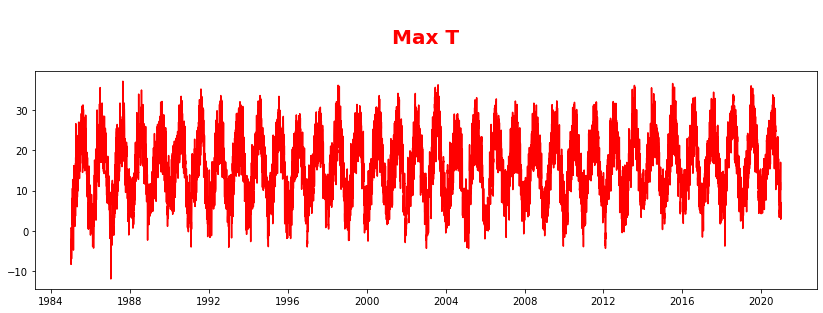

In [8]:
data = df.select("Date","MaxT","MaxRain","Year").filter(df.Year != 2021).collect()
day = [i.Date for i in data]
MaxT_training_data = [i.MaxT for i in data]
MaxRain_training_data = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_training_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')

plt.show()

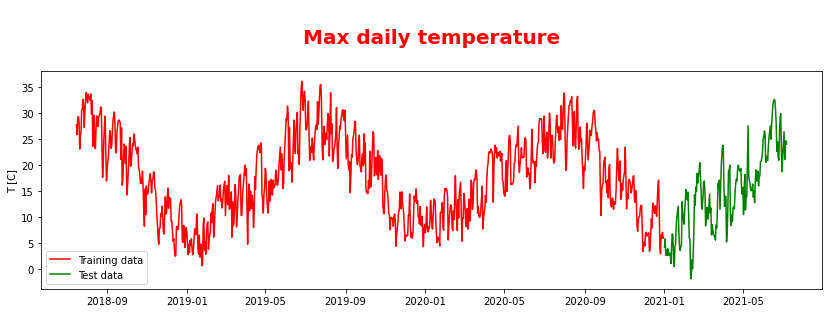

In [9]:
#test data
data = df.select("Date","MaxT","MaxRain","Year").filter(df.Year == 2021).collect()
day_test = [i.Date for i in data]
MaxT_test_data = [i.MaxT for i in data]
MaxT_test_data_all = [i.MaxT for i in data]

MaxRain_test_data = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day[-900:], MaxT_training_data[-900:], label="Training data", color = 'red')

plt.plot(day_test, MaxT_test_data, label="Test data", color = 'green')
plt.ylabel('T [C]')
plt.legend()


plt.title('\nMax daily temperature\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

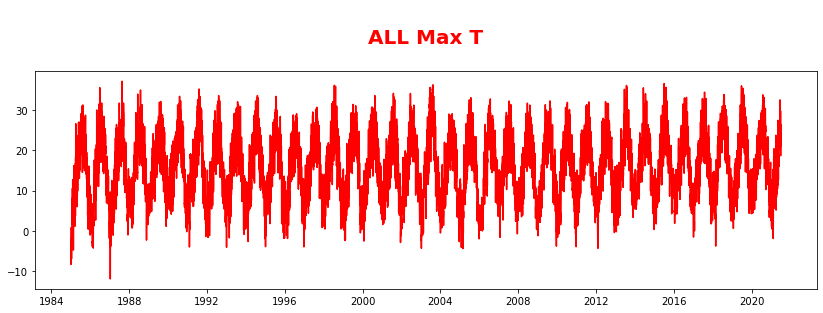

In [10]:
#test data
data = df.select("Date","MaxT","MaxRain","Year").collect()
day = [i.Date for i in data]
all_data_T = [i.MaxT for i in data]
all_data_Rain = [i.MaxRain for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, all_data_T, color = 'red')
plt.title('\nALL Max T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [11]:
batch_size = 64

In [12]:
MaxT_test_data_CUT = MaxT_test_data
while True:
    if len(MaxT_test_data_CUT)%batch_size == 0:
        break
    else:
        MaxT_test_data_CUT.append(MaxT_training_data[-1])
        MaxT_training_data = MaxT_training_data[:-1]

In [13]:
MaxT_training_data_CUT = MaxT_training_data

while True:
    if len(MaxT_training_data_CUT)%batch_size == 0:
        break
    else:
        MaxT_training_data_CUT = MaxT_training_data_CUT[1:]

In [14]:

length  = (len(MaxT_test_data_CUT))

In [15]:
# Set time steps to 7 days
timesteps= 3
# Adding timesteps * 2
upper_train = length + timesteps*2
print(upper_train)

198


In [16]:
regressor = load_model("./model_trained-1.h5")

In [17]:
sc = MinMaxScaler(feature_range = (0, 1))


In [19]:

test_length = len(MaxT_test_data_CUT)

upper_test = test_length + timesteps*2


In [20]:

#subsetting
MaxT_test_data_CUT_enlarged = (MaxT_test_data_CUT) + MaxT_training_data_CUT[-timesteps:]
print(len(MaxT_test_data_CUT_enlarged))
MaxT_test_data_CUT_enlarged_reshaped = np.array(MaxT_test_data_CUT_enlarged)
MaxT_test_data_CUT_enlarged_reshaped = np.reshape(MaxT_test_data_CUT_enlarged_reshaped, (MaxT_test_data_CUT_enlarged_reshaped.shape[0],1))

#scaling
MaxT_test_data_CUT_enlarged_reshaped_scaled = sc.fit_transform(np.float64(MaxT_test_data_CUT_enlarged_reshaped))

#creating input data
X_test_matrix_test = []
for i in range(timesteps, test_length + timesteps):
    X_test_matrix_test.append(MaxT_test_data_CUT_enlarged_reshaped_scaled[i-timesteps:i, 0])
X_test_matrix_test = np.array(X_test_matrix_test)


#reshaping
X_test_matrix_test = np.reshape(X_test_matrix_test, 
                                         (X_test_matrix_test.shape[0], 
                                          X_test_matrix_test.shape[1], 1))

print(X_test_matrix_test.shape)

195
(192, 3, 1)


In [21]:

prediction_y_hat = regressor.predict(X_test_matrix_test, batch_size=batch_size)
regressor.reset_states()


In [22]:
prediction_y_hat = np.reshape(prediction_y_hat, 
                                (prediction_y_hat.shape[0], 
                                prediction_y_hat.shape[1]))

prediction_y_hat = sc.inverse_transform(prediction_y_hat)


In [23]:
#creating y_pred data
prediction_y_pred = []

for j in range(0, test_length ):                            
    prediction_y_pred = np.append(prediction_y_pred, prediction_y_hat[j, 0])

# reshaping
prediction_y_pred = np.array(prediction_y_pred)
prediction_y_pred = np.reshape(prediction_y_pred, (prediction_y_pred.shape[0], 1))



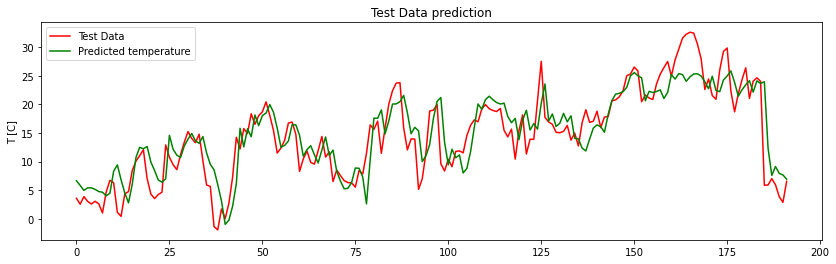

In [24]:
# Visualising the results
plt.figure(figsize=(14,4))

plt.plot(MaxT_test_data_CUT_enlarged[timesteps:], color = 'red', label = 'Test Data')
plt.plot(prediction_y_pred[0:len(prediction_y_pred)], color = 'green', label = 'Predicted temperature')
plt.title('Test Data prediction')

plt.ylabel('T [C]')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:


RMSE= np.sqrt(mean_squared_error(MaxT_test_data_CUT_enlarged[timesteps:],prediction_y_pred[0:len(prediction_y_pred) ]))
print('RMSE:',RMSE)



RMSE: 3.9291118826599


In [27]:
mean= np.mean(MaxT_test_data_CUT_enlarged[timesteps:len(prediction_y_pred)])
print(mean)
print(RMSE)
print('Loss: ' + str((RMSE/mean)*100 )+ '%') 



14.770052772843176
3.9291118826599
Loss: 26.601881138056093%
